# Prueba de OCR utilizando el modelo entrenado de la red neuronal convolucional.
### Universidad Tecnológica de la Mixteca
### Carlos Hernández Montellano
### Ingeniería en Computación
### 1002-A.

### Se importan las bibliotecas

In [6]:

import numpy as np

import tensorflow as tf
import gc

from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend

from numba import cuda

from sklearn.preprocessing import MinMaxScaler

import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [2]:
# Tensorflow revisa si existen GPU's para realizar el procesamiento en CUDA
# En este caso una GeForce 930MX compatible con 384 CUDA Cores y 2 GB de VRAM dedicada
# Si no se encuentran GPU's se usa el CPU
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6026847922748347658
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1462163865
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12293263642867963605
physical_device_desc: "device: 0, name: GeForce 930MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [3]:
# Se cargan los datos de test
test_pd = pd.read_csv('emnist/emnist-balanced-test.csv')

In [4]:
# Partición de los datos de las etiquetas y las imágenes
test_data_pd = test_pd.iloc[:, 1:]
test_labels_pd = test_pd.iloc[:, 0]

In [5]:
# One hot encoder de Pandas
test_labels_onehot_pd = pd.get_dummies(test_labels_pd)

In [6]:
# Pasamos de pandas a numpy
test_data = test_data_pd.values
y_test = test_labels_onehot_pd.values

In [7]:
# Borramos los datos de pandas para liberar memoria.
del test_labels_onehot_pd, test_pd

In [8]:
# Normalizamos datos
mms = MinMaxScaler()
x_test = mms.fit_transform(test_data)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
# Aplicamos reshape a los conuntos para que queden como matrices
TEST_PATTERN_NUMBER = x_test.shape[0]
x_test = x_test.reshape(TEST_PATTERN_NUMBER, 28, 28, 1)

In [10]:
# Forma en que está organizados los targets del dataset.
NUM_TARGETS = y_test.shape[1]
LABELS = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

In [11]:
x_test.shape, y_test.shape

((18799, 28, 28, 1), (18799, 47))

### Definición de funciones

In [12]:
# Función para evaluar el modelo con el conjunto de test
def evaluate_model (model, test_x, test_y):
    result = model.evaluate(test_x, test_y)
    print("El accuracy del modelo es: ", result[1])
    return result

In [8]:
# Función para abrir las imágenes
def open_image(name):
    im = Image.open(name).convert('LA')
    bg_colour = (255, 255, 255)
    
    # Procesar sólo si hay transparencia en la imagen
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Se necesita convertir a RGBA debido a un bug en PIL para el modo LA
        alpha = im.convert('RGBA').split()[-1]

        # Se crea un nuevo BG
        # Debe convertirse a RGBA debido a que las dos imágenes deben ser del mismo formato

        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        no_trans = bg

    else:
        no_trans = im
    
    imagen = no_trans.convert('L')
    numpy_array = np.asarray(imagen)
    # Se normalizan los valores
    img_normalizada = numpy_array/255
    return img_normalizada

In [14]:
# Función para obtener las letras contenidas en la imágen
#Separación de lineas
def get_characters(img, char_height, char_width):
    text_lines = np.int(img.shape[0]/char_height)
    chars_per_line = np.int(img.shape[1]/char_width)
    char_array = np.array([]).reshape(-1, char_height, char_width)
    for i in range(text_lines):
        for j in range(chars_per_line):
            char = img[i*char_height:i*char_height + char_height, j*char_width:j*char_width + char_width]
            char_array = np.vstack([char_array, [char.T]])
    return char_array

In [38]:
# Función que genera el texto de salida según la predicción
def decode_prediction(predict_array, characters, img, char_height, char_width):
    str = ''
    text_lines = np.int(img.shape[0]/char_height)
    chars_per_line = np.int(img.shape[1]/char_width)
    for i in range(text_lines):
        for j in range(chars_per_line):
            if(characters[i * chars_per_line + j].max() > 0.2):
                str += LABELS[predict_array[i * chars_per_line + j]]
            else:
                str += ' '
        str += '\n'
    return str

In [69]:
# Función que evalúa el accuracy del clasificador
def test_evaluator (predict_array, text, characters, img, char_height, char_width):
    prediction_counter = 0
    text_index = 0
    
    # Primero se quitan espacios y saltos de línea
    letters = text.replace(" ", "").replace("\n", "")
    #Se sustituyen las minúsculas por mayúsculas, en cuyo target sólo
    # existe su versión en mayúscula
    letters = letters.replace("c", "C")
    letters = letters.replace("i", "I")
    letters = letters.replace("j", "J")
    letters = letters.replace("k", "K")
    letters = letters.replace("l", "L")
    letters = letters.replace("m", "M")
    letters = letters.replace("o", "O")
    letters = letters.replace("p", "P")
    letters = letters.replace("s", "S")
    letters = letters.replace("u", "U")
    letters = letters.replace("v", "V")
    letters = letters.replace("w", "W")
    letters = letters.replace("x", "X")
    letters = letters.replace("y", "Y")
    letters = letters.replace("z", "Z")
    
    text_lines = np.int(img.shape[0]/char_height)
    chars_per_line = np.int(img.shape[1]/char_width)
    for i in range(text_lines):
        for j in range(chars_per_line):
            if (characters[i * chars_per_line + j].max() > 0.2):
                print(LABELS[predict_array[i * chars_per_line + j]] + ' == ' + letters[text_index] + '?')
                if (LABELS[predict_array[i * chars_per_line + j]] == letters[text_index]):
                    prediction_counter += 1
                    print(" Yes. Prediction counter = " + str(prediction_counter) + '\n')
                else:
                    print(" No\n")
                text_index += 1
    acc = prediction_counter/len(letters)
    return acc

### Carga del modelo entrenado de la CNN

In [16]:
# Se carga el modelo del JSON
json_file = open('CNN_model_EMNIST_GPU.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
CNN_model = model_from_json(loaded_model_json)
# Se cargan los pesos del entrenamiento del HDF5
CNN_model.load_weights("CNN_model_EMNIST_GPU.h5")
print("Se ha cargado el modelo con éxito")
# Se compila el modelo
CNN_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
# Se muestra la arquitectura del modelo
CNN_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Se ha cargado el modelo con éxito
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_v1_8 (Ba (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 32)        25632     
_____________________________________________________

## Evaluación del modelo

In [17]:
# Se evalúa el modelo cargado con el conjunto balanceado de test proporcionado por EMNIST
evaluate_model (CNN_model, x_test, y_test)

18799/18799 [==============================] - 8s 425us/sample - loss: 0.3024 - acc: 0.8902
El accuracy del modelo es:  0.8901537


[0.30237727504416, 0.8901537]

### Prueba de OCR

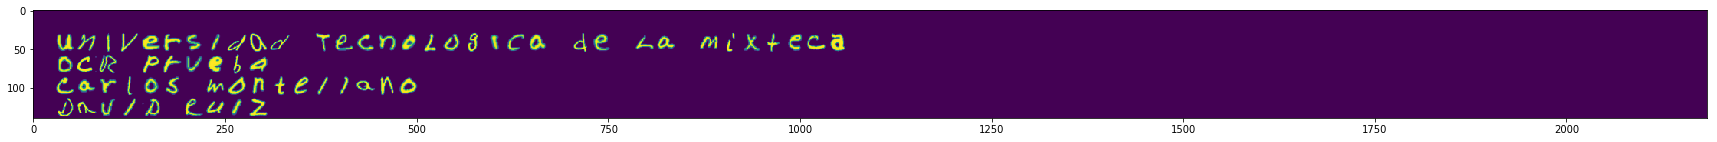

In [15]:
# Se carga y se muestra la imagen de prueba
img1 = open_image('test_images/1.png')
plt.figure(figsize=(30, 4))
plt.imshow(img1)

In [3]:
# Texto de la imagen de prueba
text = "Universidad Tecnologica de la Mixteca\nOCR Prueba\nCarlos Montellano\nDavid Ruiz"
print(text)

Universidad Tecnologica de la Mixteca
OCR Prueba
Carlos Montellano
David Ruiz


In [25]:
# Aquí se extraen los caracteres de la imagen y se
# les hace reshape para que queden en el formato que
# recibe el modelo
characters = get_characters(img1, 28, 28)
characters = characters.reshape(-1, 28, 28, 1)

In [26]:
# Se realiza el predict de las imagenes. El predict arroja en número
# decimal la clase a la que pertenece un patrón
predict_array = CNN_model.predict_classes(characters)

In [27]:
# Se muestran los resultados predichos por el modelo entrenado.
#
# Se puede observar que los números 21 corresponden a los espacios
# vacíos de la imágen debido a que no se le enseñó a la red neuronal
# a identificar espacios en blanco en su conjunto de entrenamiento.
# Por lo tanto, el clasificador lo interpreta como una letra L.
predict_array

array([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 30, 43, 21, 31, 39, 45,
       28, 21, 38, 36, 38, 21, 29, 39, 12, 43, 24, 21, 24, 41, 18, 12, 36,
       21, 38, 39, 21, 21, 36, 21, 22, 18, 33, 46, 39, 12, 36, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 24, 12, 27, 21, 25, 45, 31, 39, 37, 36, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21

In [40]:
# Se realiza una decodificación del arreglo predicho para convertir
# los resultados a texto y poder desplegarlo.
# En esta función es donde se valida lo de los espacios en blanco,
# y se hace a través de la imagen original.
predicted_text = decode_prediction(predict_array, characters, img1, 28, 28)
print(predicted_text)

                                                                              
 UnLVerSLdad TeCnOLOgICa de La MIXteCa                                        
 OCR PrVeba                                                                   
 CarLOS M0nteLLanO                                                            
 DaVLD eUIZ                                                                   



In [70]:
# Se revisa el accuracy comparando el texto predicho y el
# texto original. Hay que recordar que algunas letras en
# mayúscula no tienen su correspondiente en minúscula, por lo
# tanto, las que no lo tienen, convierten el texto original
# de minúscula a mayúscula.
acc = test_evaluator(predict_array, text, characters, img1, 28, 28)

U == U?
 Yes. Prediction counter = 1

n == n?
 Yes. Prediction counter = 2

L == I?
 No

V == V?
 Yes. Prediction counter = 3

e == e?
 Yes. Prediction counter = 4

r == r?
 Yes. Prediction counter = 5

S == S?
 Yes. Prediction counter = 6

L == I?
 No

d == d?
 Yes. Prediction counter = 7

a == a?
 Yes. Prediction counter = 8

d == d?
 Yes. Prediction counter = 9

T == T?
 Yes. Prediction counter = 10

e == e?
 Yes. Prediction counter = 11

C == C?
 Yes. Prediction counter = 12

n == n?
 Yes. Prediction counter = 13

O == O?
 Yes. Prediction counter = 14

L == L?
 Yes. Prediction counter = 15

O == O?
 Yes. Prediction counter = 16

g == g?
 Yes. Prediction counter = 17

I == I?
 Yes. Prediction counter = 18

C == C?
 Yes. Prediction counter = 19

a == a?
 Yes. Prediction counter = 20

d == d?
 Yes. Prediction counter = 21

e == e?
 Yes. Prediction counter = 22

L == L?
 Yes. Prediction counter = 23

a == a?
 Yes. Prediction counter = 24

M == M?
 Yes. Prediction counter = 25

I == I?


In [71]:
print("La exactitud de la prueba es " + str(acc))

La exactitud de la prueba es 0.8955223880597015


In [5]:
letters2 = text.replace(" ", "")
print(letters2)

UniversidadTecnologicadelaMixteca
OCRPrueba
CarlosMontellano
DavidRuiz


In [8]:
print(str(len("UniversidadTecnologicadelaMixteca")) + "\n")
print(str(len("OCRPrueba")) + "\n")
print(str(len("CarlosMontellano")) + "\n")
print(str(len("DavidRuiz")) + "\n")

33

9

16

9

